In [1]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, parallel_backend
import pandas as pd

from decrease_bound_utils import psiam_tied_data_gen_wrapper_bound_change

# Params

In [2]:
V_A = 1.1
theta_A = 1.8

rate_lambda = 0.14
T_0 = 0.66 * (1e-3)
theta_E = 40.5

t_A_aff = 0.03
t_E_aff = 0.05
t_motor = 0.03

Z_E = 0
L = 0.5

N_sim = int(50e3)
dt = 1e-4

bound_step_size = 0.5
N_print = int(10e3)

N_params = 10

# ABL, ILD, stim and led times from data

In [3]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

ABL_arr = df['ABL'].unique()
ABL_arr.sort()

ILD_arr = df['ILD'].unique()
ILD_arr.sort()

# percentage of LED on trials
frac_of_led = df['LED_trial'].values.sum() / df['LED_trial'].values.size
print(f'frac_of_led: {frac_of_led}')

frac_of_led: 0.33939811074203746


# simulate many

In [4]:
bound_change_results_dict = {}
for i in range(N_params):
    new_bound = theta_E - i * bound_step_size

    with parallel_backend('threading', n_jobs=-1):
        sim_results = Parallel()(
            delayed(psiam_tied_data_gen_wrapper_bound_change)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E,\
                                                               t_A_aff, t_E_aff, t_motor, L,t_stim_and_led_tuple, new_bound, iter_num, \
                                                                N_print, dt)
            for iter_num in range(N_sim)
        )

    print(f'V_A: {V_A}, new bound: {new_bound}')

    bound_change_results_dict[i] = {'results': sim_results, 'new_bound':  new_bound }

os id: 2546703, In iter_num: 0, ABL: 40, ILD: 16.0, t_stim: 0.245176799020887
os id: 2546703, In iter_num: 10000, ABL: 60, ILD: -8.0, t_stim: 0.495675115755874
os id: 2546703, In iter_num: 20000, ABL: 60, ILD: -1.0, t_stim: 0.384194447390211
os id: 2546703, In iter_num: 30000, ABL: 40, ILD: 16.0, t_stim: 0.297040503739674
os id: 2546703, In iter_num: 40000, ABL: 40, ILD: -16.0, t_stim: 0.698042869855106
V_A: 1.1, new bound: 40.5
os id: 2546703, In iter_num: 0, ABL: 20, ILD: 1.0, t_stim: 1.30653121081401
os id: 2546703, In iter_num: 10000, ABL: 40, ILD: 1.0, t_stim: 0.810678414808042
os id: 2546703, In iter_num: 20000, ABL: 20, ILD: -16.0, t_stim: 0.272143639357106
os id: 2546703, In iter_num: 30000, ABL: 40, ILD: -4.0, t_stim: 0.280609157258901
os id: 2546703, In iter_num: 40000, ABL: 20, ILD: 16.0, t_stim: 1.45347855607664
V_A: 1.1, new bound: 40.0
os id: 2546703, In iter_num: 0, ABL: 60, ILD: -1.0, t_stim: 1.51546757593757
os id: 2546703, In iter_num: 10000, ABL: 60, ILD: -1.0, t_sti

# see aborts distr

In [5]:
# new_bound_ON = []
# control_bound_ON = []

# new_bound_off = []
# control_bound_off = []

# for res in bound_change_results_dict[0]['results']:
#     if res['is_LED_trial']:
#         if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
#             new_bound_ON.append(res['rt'] - res['t_stim'])
#     elif not res['is_LED_trial']:
#         if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
#             new_bound_off.append(res['rt'] - res['t_stim'])

# for res in bound_change_results_dict[4]['results']:
#     if res['is_LED_trial']:
#         if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
#             control_bound_ON.append(res['rt'] - res['t_stim'])
#     elif not res['is_LED_trial']:
#         if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
#             control_bound_off.append(res['rt'] - res['t_stim'])

In [6]:
# plt.figure(figsize=(10,5))

# plt.subplot(1,2,1)
# plt.hist(control_bound_ON, bins=50, alpha=0.5,  density=True, label='control noise OFF', color='r', histtype='step')
# plt.hist(control_bound_off, bins=50, alpha=0.5, density=True, label='control on', color='b', histtype='step')
# plt.title('control')
# plt.xlabel('RT - stim time')
# plt.ylabel('Density')
# plt.legend()

# plt.subplot(1,2,2)
# plt.hist(new_bound_ON, bins=50, alpha=0.5,  density=True, label='new noise ON', color='r', histtype='step')
# plt.hist(new_bound_off, bins=50, alpha=0.5,  density=True, label='new noise OFF', color='b', histtype='step')
# plt.title(f'new bound: {bound_change_results_dict[0]["new_bound"]}')
# plt.xlabel('RT - stim time')
# plt.ylabel('Density')
# plt.legend()

# psychometric

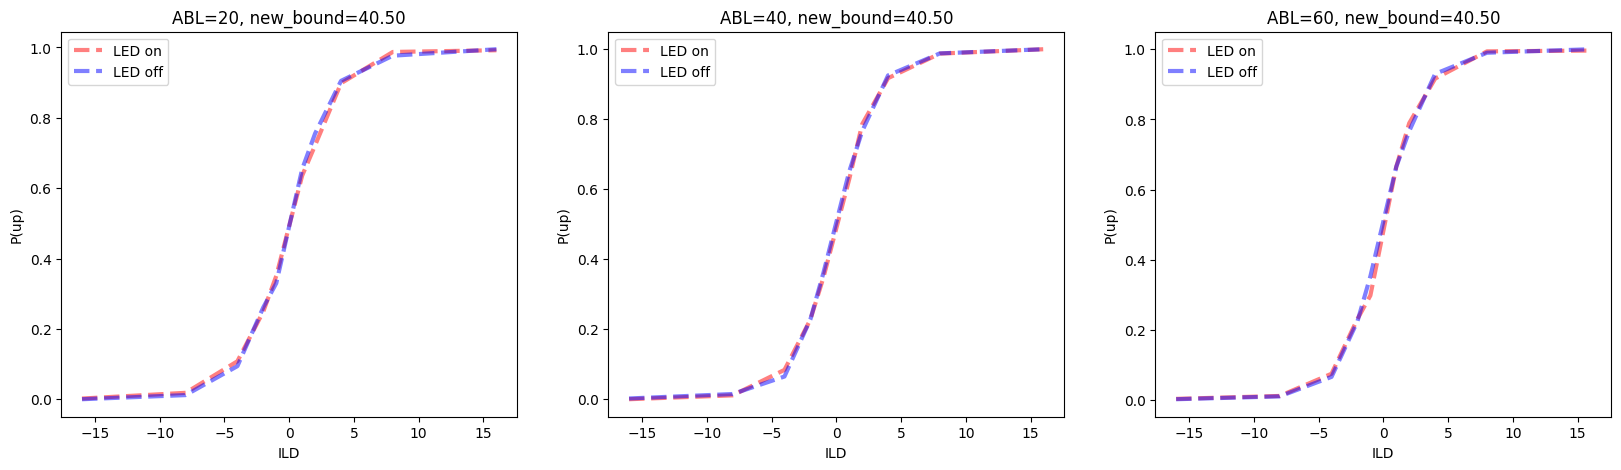

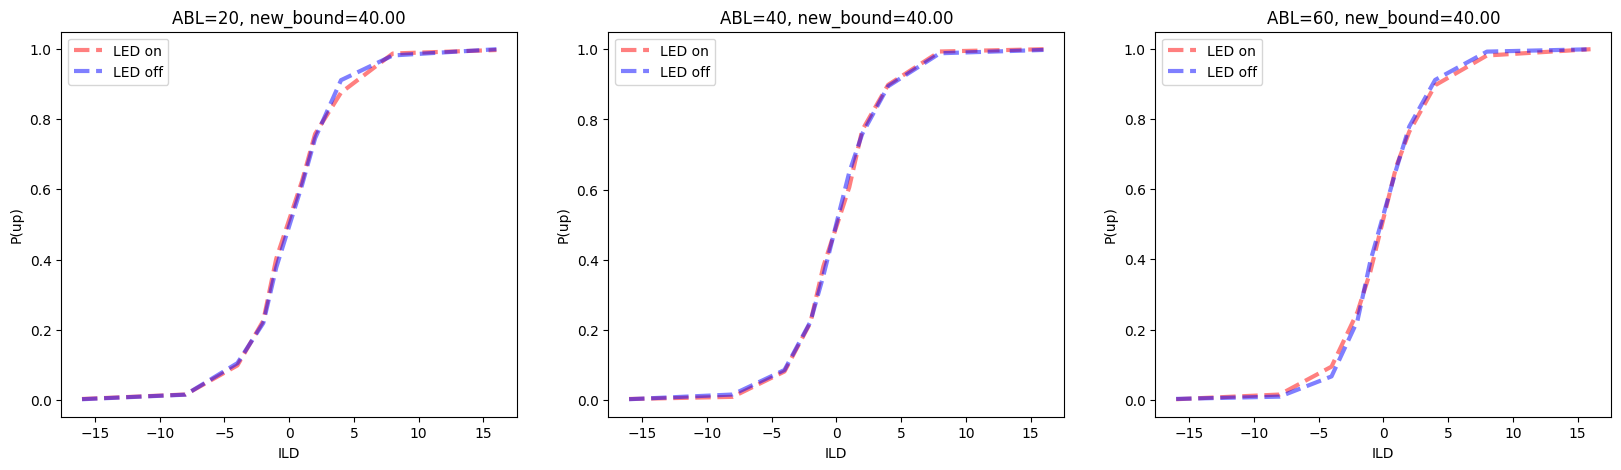

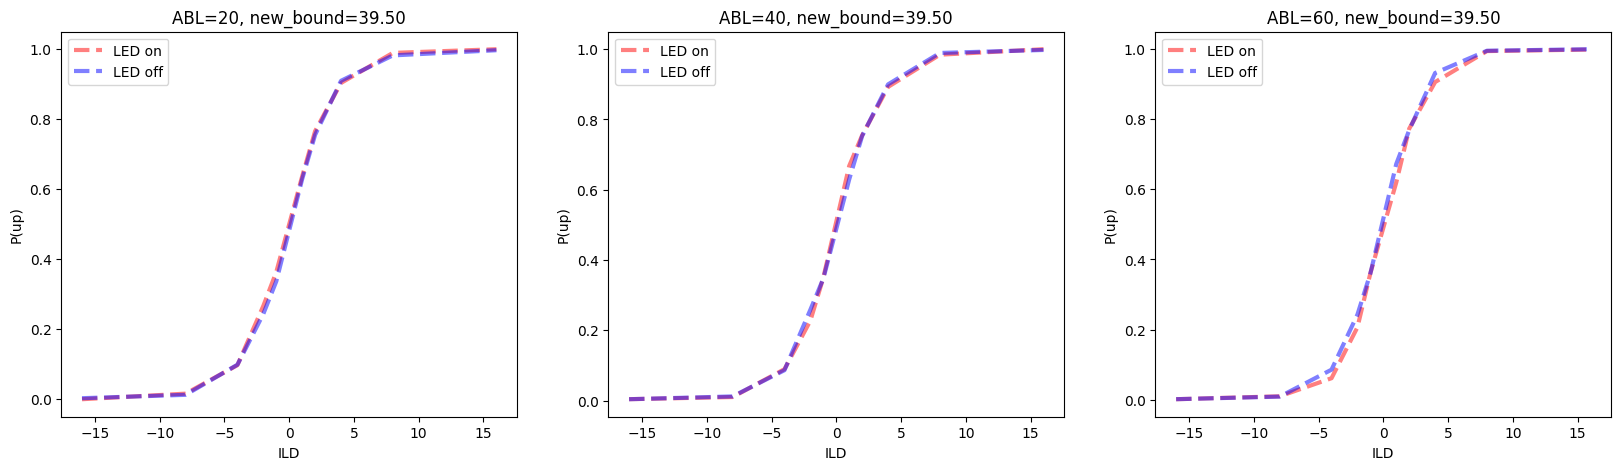

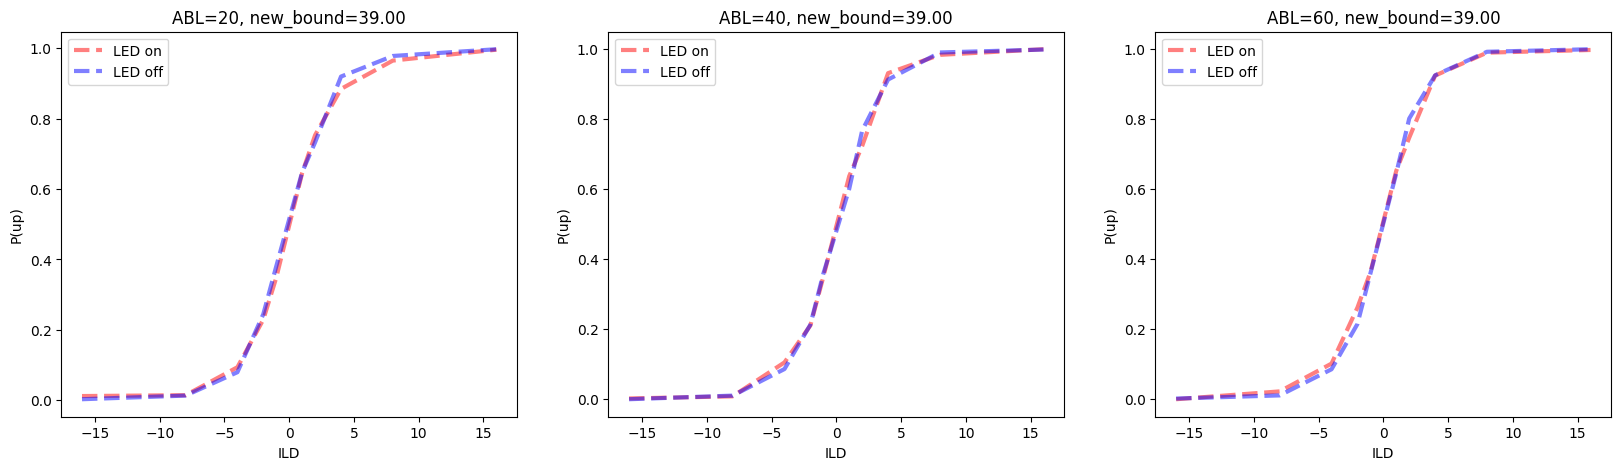

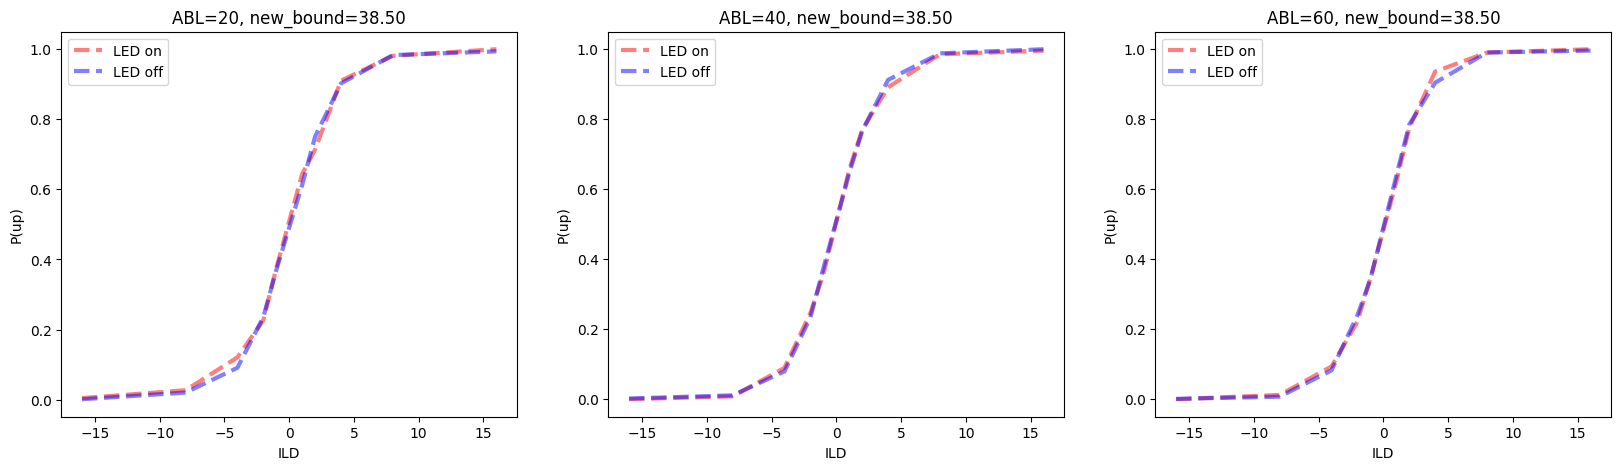

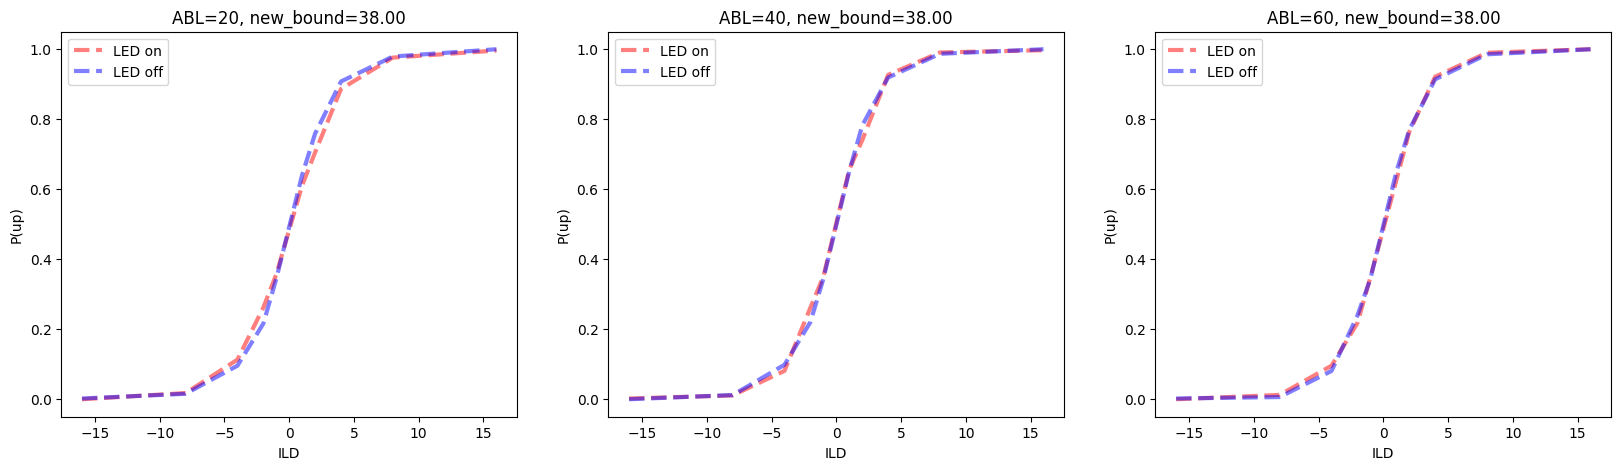

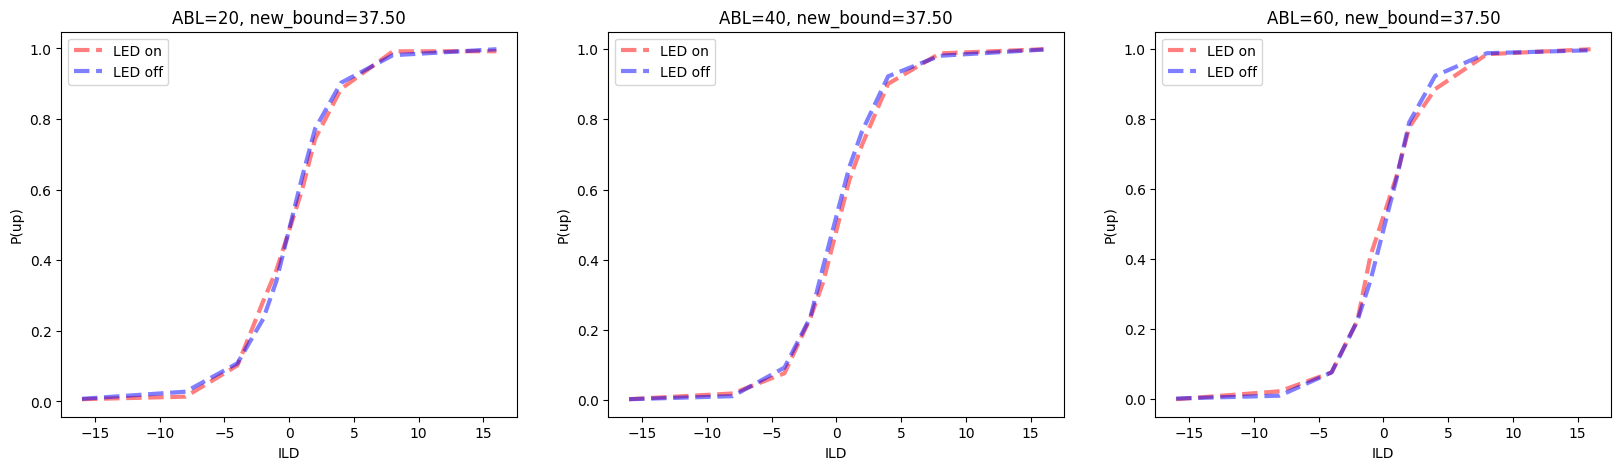

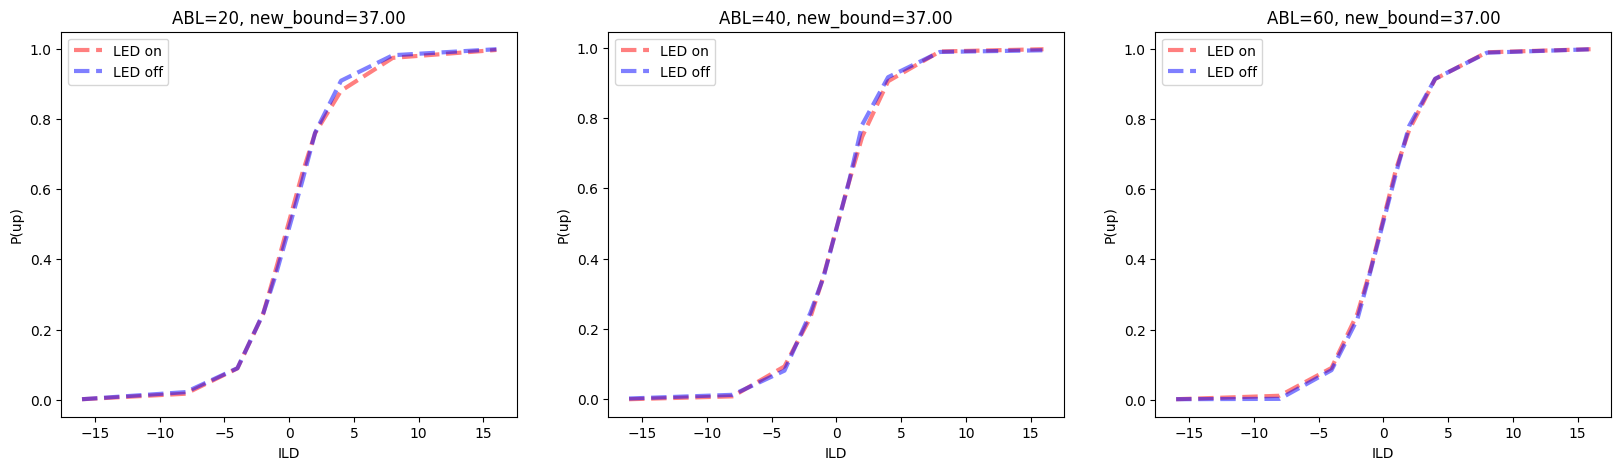

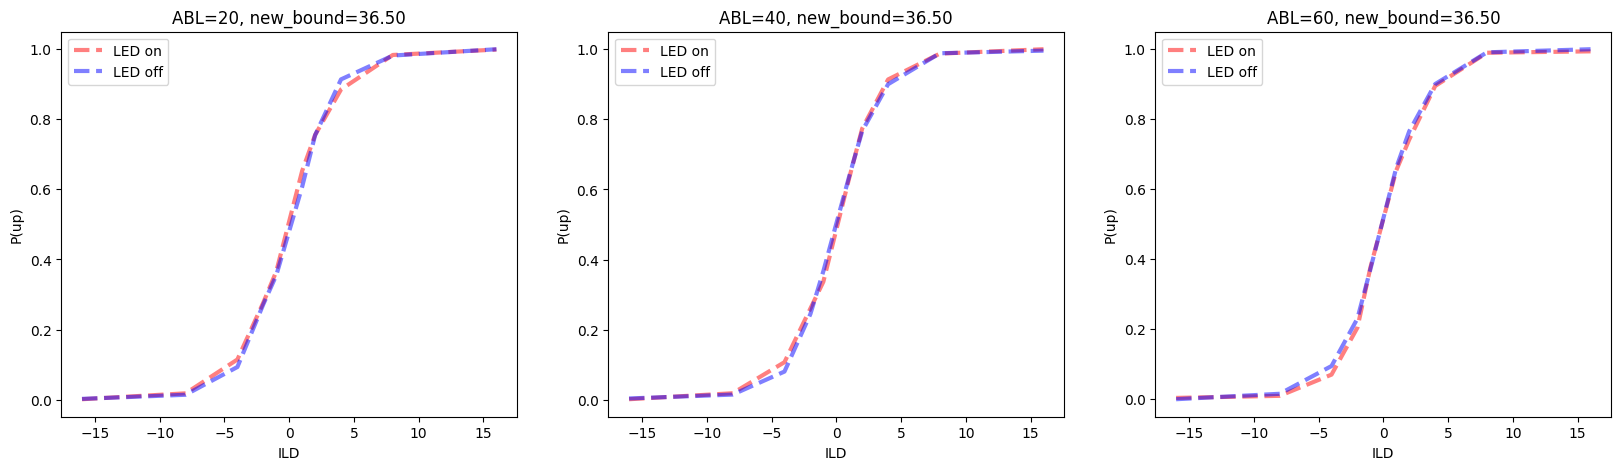

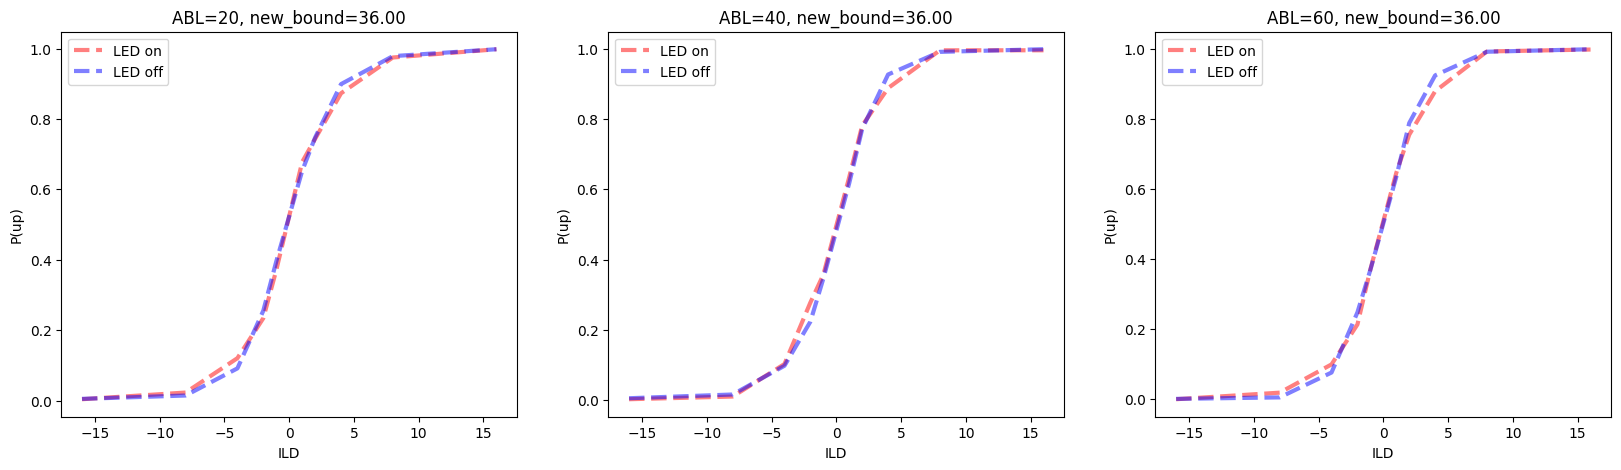

In [7]:
for i in range(0, N_params):
    # for each V_A
    each_bound_results = bound_change_results_dict[i]['results']
    new_bound = bound_change_results_dict[i]['new_bound']

    num_up_on = {}; num_trials_on = {}
    num_up_off = {}; num_trials_off = {}
    for ABL in ABL_arr:
        num_up_on[ABL] = np.zeros_like(ILD_arr)
        num_trials_on[ABL] = np.zeros_like(ILD_arr)

        num_up_off[ABL] = np.zeros_like(ILD_arr)
        num_trials_off[ABL] = np.zeros_like(ILD_arr)

    
    for res in each_bound_results:
        ABL = res['ABL']
        ILD = res['ILD']
        is_LED_trial = res['is_LED_trial']
        if is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        elif not is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

        

        

    plt.figure(figsize=(20,5))
    for a, ABL in enumerate(ABL_arr):
        plt.subplot(1, len(ABL_arr), a+1)
        plt.title(f'ABL={ABL}, new_bound={new_bound:.2f}')

        
        plt.plot(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], label='LED on', linestyle='--', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, num_up_off[ABL]/num_trials_off[ABL], label='LED off', linestyle='--', color='b', lw=3, alpha=0.5)
        
        plt.legend()
        plt.xlabel('ILD'); plt.ylabel('P(up)');

# percentiles

In [8]:
base_bound_data = bound_change_results_dict[0]['results']


# change V_A
new_bound_idx = 3
new_bound_value = bound_change_results_dict[new_bound_idx]['new_bound']
new_bound_data = bound_change_results_dict[new_bound_idx]['results']

In [9]:
base_on_abl_ild = {}
base_off_abl_ild = {}

new_on_abl_ild = {}
new_off_abl_ild = {}

for ABL in ABL_arr:
    for ILD in ILD_arr:
        base_on_abl_ild[(ABL, int(ILD))] = []
        base_off_abl_ild[(ABL, int(ILD))] = []

        new_on_abl_ild[(ABL, int(ILD))] = []
        new_off_abl_ild[(ABL, int(ILD))] = []

for res in base_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_led']:
            base_on_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])
    elif not is_LED_trial:
        if res['rt'] > res['t_led']:
            base_off_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])


for res in new_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_led']:
            new_on_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])
    elif not is_LED_trial:
        if res['rt'] > res['t_led']:
            new_off_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])

In [10]:
base_on_percentiles_dict = {}
base_off_percentiles_dict = {}

new_on_percentiles_dict = {}
new_off_percentiles_dict = {}

percentiles = [10, 30, 50, 70, 90]


for ABL in ABL_arr:
    base_on_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))
    base_off_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))

    new_on_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))
    new_off_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))


for ABL in ABL_arr:
    for ild_idx,ILD in enumerate(ILD_arr):
        for p, percentile in enumerate(percentiles):
            base_on_percentiles_dict[ABL][(p, ild_idx)] = np.percentile(base_on_abl_ild[ABL, int(ILD)], percentile)
            base_off_percentiles_dict[ABL][p, ild_idx] = np.percentile(base_off_abl_ild[ABL, int(ILD)], percentile)

            new_on_percentiles_dict[ABL][p, ild_idx] = np.percentile(new_on_abl_ild[ABL, int(ILD)], percentile)
            new_off_percentiles_dict[ABL][p, ild_idx] = np.percentile(new_off_abl_ild[ABL, int(ILD)], percentile)

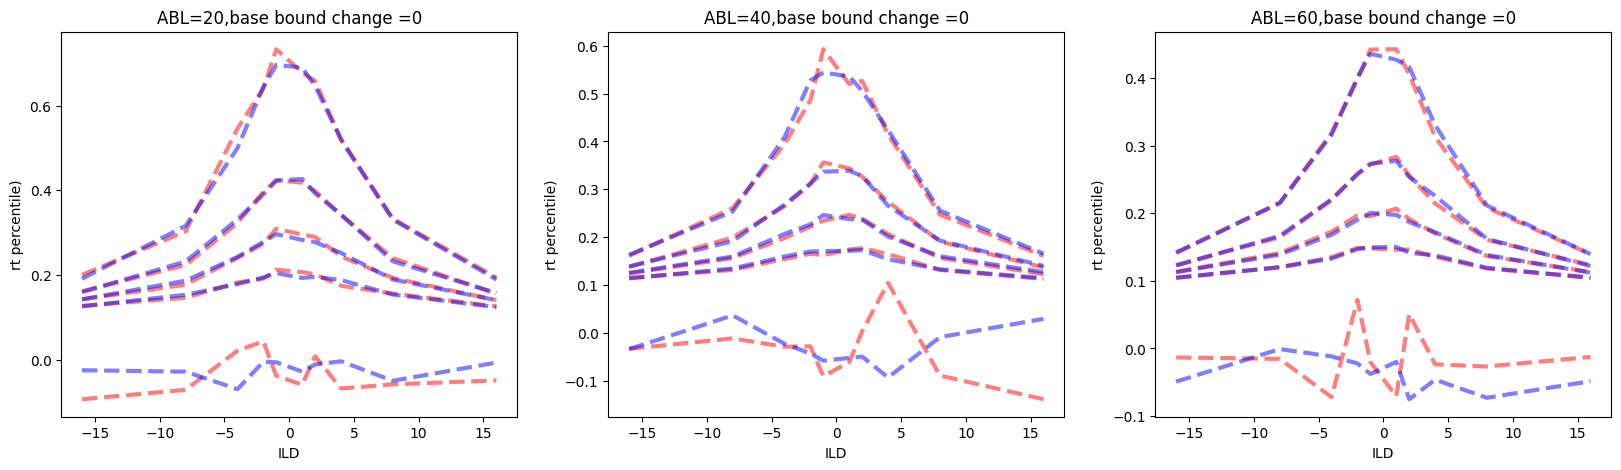

In [11]:
# plot
plt.figure(figsize=(20,5))
for a, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), a+1)
    plt.title(f'ABL={ABL},base bound change ={0}')
    for p, percentile in enumerate(percentiles):
        plt.plot(ILD_arr, base_on_percentiles_dict[ABL][p], label=f'base ON {percentile}', linestyle='--', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, base_off_percentiles_dict[ABL][p], label=f'base OFF {percentile}', linestyle='--', color='b', lw=3, alpha=0.5)



    plt.xlabel('ILD'); plt.ylabel('rt percentile)');

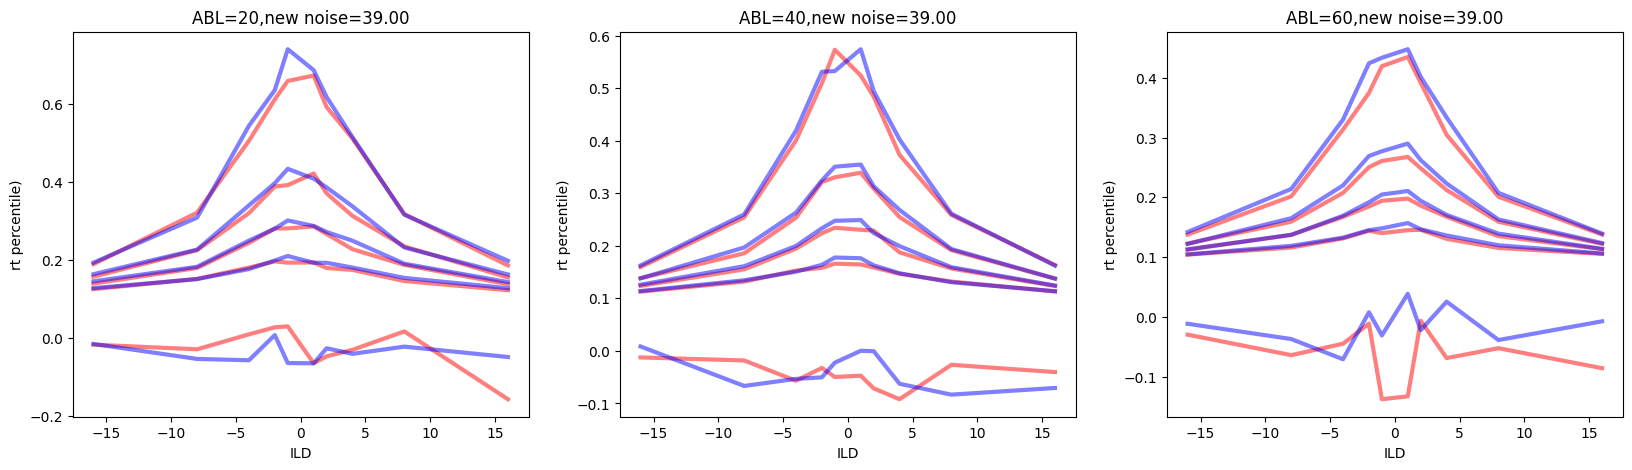

In [12]:


# plot
plt.figure(figsize=(20,5))
for a, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), a+1)
    plt.title(f'ABL={ABL},new noise={new_bound_value:.2f}')
    for p, percentile in enumerate(percentiles):
        plt.plot(ILD_arr, new_on_percentiles_dict[ABL][p], label=f'new ON {percentile}', linestyle='-', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, new_off_percentiles_dict[ABL][p], label=f'new OFF {percentile}', linestyle='-', color='b', lw=3, alpha=0.5)



    plt.xlabel('ILD'); plt.ylabel('rt percentile)');

# chronometric

In [13]:
positive_ILD_arr = ILD_arr[ILD_arr > 0]

# base and new init- collect rt
base_rt_abl_ild_on = {}
base_rt_abl_ild_off = {}

new_rt_abl_ild_on = {}
new_rt_abl_ild_off = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_rt_abl_ild_on[(ABL, ILD)] = []
        base_rt_abl_ild_off[(ABL, ILD)] = []

        new_rt_abl_ild_on[(ABL, ILD)] = []
        new_rt_abl_ild_off[(ABL, ILD)] = []
#  base
for res in base_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            base_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            base_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])

# new
for res in new_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            new_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            new_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
# base
base_on_mean = {}
base_on_std_err = {}

base_off_mean = {}
base_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_on_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_on[(ABL, ILD)])
        base_on_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_on[(ABL, ILD)]))

        base_off_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_off[(ABL, ILD)])
        base_off_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_off[(ABL, ILD)]))
# new
new_on_mean = {}
new_on_std_err = {}

new_off_mean = {}
new_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        new_on_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_on[(ABL, ILD)])
        new_on_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_on[(ABL, ILD)]))

        new_off_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_off[(ABL, ILD)])
        new_off_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_off[(ABL, ILD)]))

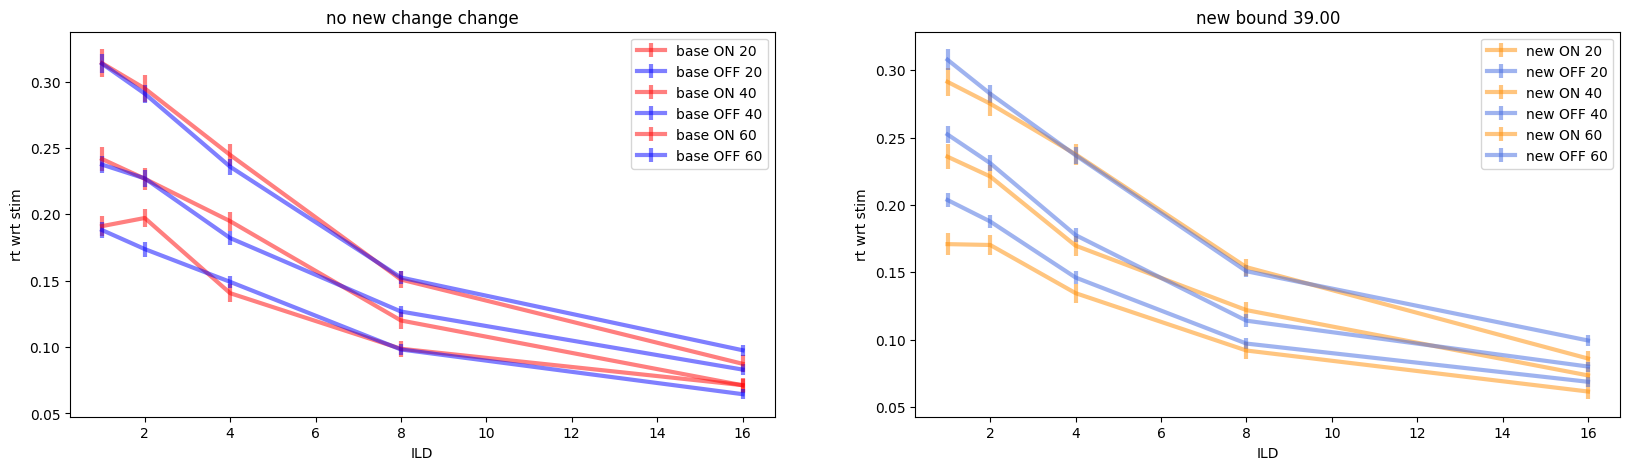

In [14]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
# base - mean with std err vs pos ILD
for ABL in ABL_arr:
    plt.errorbar(positive_ILD_arr, [base_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[base_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'base ON {ABL}', color='r', lw=3, alpha=0.5)
    plt.errorbar(positive_ILD_arr, [base_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[base_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'base OFF {ABL}', color='b', lw=3, alpha=0.5)
    plt.legend()
    plt.xlabel('ILD'); plt.ylabel('rt wrt stim')
    plt.title('no new change change')

plt.subplot(1,2,2)
# new - mean with std err vs pos ILD
for ABL in ABL_arr:
    plt.errorbar(positive_ILD_arr, [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new ON {ABL}', color='darkorange', lw=3, alpha=0.5)
    plt.errorbar(positive_ILD_arr, [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new OFF {ABL}', color='royalblue', lw=3, alpha=0.5)
    plt.legend()
    plt.xlabel('ILD'); plt.ylabel('rt wrt stim')
    plt.title(f'new bound {new_bound_value:.2f}')

# chronometric w/o aborts, compaed with data

In [15]:
df_1 = df [ df['LED_trial'] == 1 ]
df_0 = df [ df['LED_trial'] == 0 ]

led_on_abl_ild = {}
led_off_abl_ild = {}

positive_ILD_arr = ILD_arr[ILD_arr > 0]

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_abl_ild[(ABL, ILD)] = []
        led_off_abl_ild[(ABL, ILD)] = []

# ON
for _, row in df_1.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_on_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])
    
# OFF
for _, row in df_0.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_off_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])


# on and off mean and std
led_on_mean = {}
led_on_std_err = {}

led_off_mean = {}
led_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_mean[(ABL, ILD)] = np.mean(led_on_abl_ild[(ABL, ILD)])
        led_on_std_err[(ABL, ILD)] = np.std(led_on_abl_ild[(ABL, ILD)])/np.sqrt(len(led_on_abl_ild[(ABL, ILD)]))

        led_off_mean[(ABL, ILD)] = np.mean(led_off_abl_ild[(ABL, ILD)])
        led_off_std_err[(ABL, ILD)] = np.std(led_off_abl_ild[(ABL, ILD)])/np.sqrt(len(led_off_abl_ild[(ABL, ILD)]))

In [16]:
positive_ILD_arr = ILD_arr[ILD_arr > 0]

# base and new init- collect rt
base_rt_abl_ild_on = {}
base_rt_abl_ild_off = {}

new_rt_abl_ild_on = {}
new_rt_abl_ild_off = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_rt_abl_ild_on[(ABL, ILD)] = []
        base_rt_abl_ild_off[(ABL, ILD)] = []

        new_rt_abl_ild_on[(ABL, ILD)] = []
        new_rt_abl_ild_off[(ABL, ILD)] = []
#  base
for res in base_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            base_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            base_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])

# new
for res in new_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            new_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            new_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
# base
base_on_mean = {}
base_on_std_err = {}

base_off_mean = {}
base_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_on_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_on[(ABL, ILD)])
        base_on_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_on[(ABL, ILD)]))

        base_off_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_off[(ABL, ILD)])
        base_off_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_off[(ABL, ILD)]))
# new
new_on_mean = {}
new_on_std_err = {}

new_off_mean = {}
new_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        new_on_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_on[(ABL, ILD)])
        new_on_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_on[(ABL, ILD)]))

        new_off_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_off[(ABL, ILD)])
        new_off_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_off[(ABL, ILD)]))

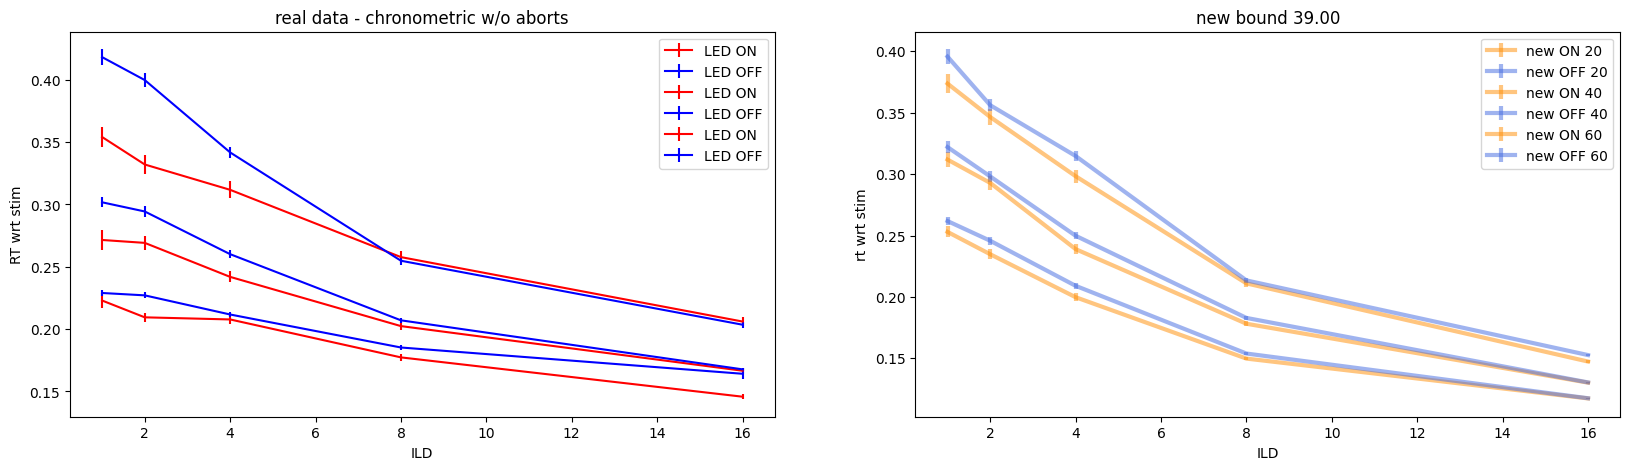

In [17]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for ABL in ABL_arr:
    # mean and err vs positive ILD
    plt.errorbar(positive_ILD_arr, [led_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED ON', color='red')
    plt.errorbar(positive_ILD_arr, [led_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED OFF', color='blue')

    plt.xlabel('ILD')
    plt.ylabel('RT wrt stim')
    plt.legend()
    plt.title('real data - chronometric w/o aborts')


plt.subplot(1,2,2)
# new - mean with std err vs pos ILD
for ABL in ABL_arr:
    plt.errorbar(positive_ILD_arr, [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new ON {ABL}', color='darkorange', lw=3, alpha=0.5)
    plt.errorbar(positive_ILD_arr, [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new OFF {ABL}', color='royalblue', lw=3, alpha=0.5)
    plt.legend()
    plt.xlabel('ILD'); plt.ylabel('rt wrt stim')
    plt.title(f'new bound {new_bound_value:.2f}')

# tachometric

In [18]:
# base
bin_width = 0.05
t_bins = np.arange(0, 3, bin_width)

base_total_and_up_counts_dict_on = {}
base_total_and_up_counts_dict_off = {}

for ABL in ABL_arr:
    for ILD in ILD_arr:
        base_total_and_up_counts_dict_on[(ABL, ILD)] = {}
        base_total_and_up_counts_dict_on[(ABL, ILD)]['total'] = np.zeros_like(t_bins)
        base_total_and_up_counts_dict_on[(ABL, ILD)]['up'] = np.zeros_like(t_bins)
        
        base_total_and_up_counts_dict_off[(ABL, ILD)] = {}
        base_total_and_up_counts_dict_off[(ABL, ILD)]['total'] = np.zeros_like(t_bins)
        base_total_and_up_counts_dict_off[(ABL, ILD)]['up'] = np.zeros_like(t_bins)


for row in base_bound_data:
    ABL = row['ABL']; ILD = row['ILD']

    if row['is_LED_trial'] == 1:
        if row['rt'] > row['t_stim']:
            rt_wrt_stim = row['rt'] - row['t_stim']
            rt_wrt_stim_idx = int(rt_wrt_stim // bin_width)

            base_total_and_up_counts_dict_on[(ABL, ILD)]['total'][rt_wrt_stim_idx] += 1
            if row['choice'] == 1:
                base_total_and_up_counts_dict_on[(ABL, ILD)]['up'][rt_wrt_stim_idx] += 1

    elif not row['is_LED_trial']:
        if row['rt'] > row['t_stim']:
            rt_wrt_stim = row['rt'] - row['t_stim']
            rt_wrt_stim_idx = int(rt_wrt_stim // bin_width)

            base_total_and_up_counts_dict_off[(ABL, ILD)]['total'][rt_wrt_stim_idx] += 1
            if row['choice'] == 1:
                base_total_and_up_counts_dict_off[(ABL, ILD)]['up'][rt_wrt_stim_idx] += 1
 

In [19]:
# new bound
new_total_and_up_counts_dict_on = {}
new_total_and_up_counts_dict_off = {}

for ABL in ABL_arr:
    for ILD in ILD_arr:
        new_total_and_up_counts_dict_on[(ABL, ILD)] = {}
        new_total_and_up_counts_dict_on[(ABL, ILD)]['total'] = np.zeros_like(t_bins)
        new_total_and_up_counts_dict_on[(ABL, ILD)]['up'] = np.zeros_like(t_bins)
        
        new_total_and_up_counts_dict_off[(ABL, ILD)] = {}
        new_total_and_up_counts_dict_off[(ABL, ILD)]['total'] = np.zeros_like(t_bins)
        new_total_and_up_counts_dict_off[(ABL, ILD)]['up'] = np.zeros_like(t_bins)

for row in new_bound_data:
    ABL = row['ABL']; ILD = row['ILD']

    if row['is_LED_trial'] == 1:
        if row['rt'] > row['t_stim']:
            rt_wrt_stim = row['rt'] - row['t_stim']
            rt_wrt_stim_idx = int(rt_wrt_stim // bin_width)

            new_total_and_up_counts_dict_on[(ABL, ILD)]['total'][rt_wrt_stim_idx] += 1
            if row['choice'] == 1:
                new_total_and_up_counts_dict_on[(ABL, ILD)]['up'][rt_wrt_stim_idx] += 1

    elif not row['is_LED_trial']:
        if row['rt'] > row['t_stim']:
            rt_wrt_stim = row['rt'] - row['t_stim']
            rt_wrt_stim_idx = int(rt_wrt_stim // bin_width)

            new_total_and_up_counts_dict_off[(ABL, ILD)]['total'][rt_wrt_stim_idx] += 1
            if row['choice'] == 1:
                new_total_and_up_counts_dict_off[(ABL, ILD)]['up'][rt_wrt_stim_idx] += 1


/tmp/ipykernel_2546703/2610799276.py:15: RuntimeWarning: invalid value encountered in divide
  plt.plot(t_bins, base_total_and_up_counts_dict_on[(ABL, ILD)]['up']/base_total_and_up_counts_dict_on[(ABL, ILD)]['total'],  color='red', label='LED ON')
/tmp/ipykernel_2546703/2610799276.py:16: RuntimeWarning: invalid value encountered in divide
  plt.plot(t_bins, base_total_and_up_counts_dict_off[(ABL, ILD)]['up']/base_total_and_up_counts_dict_off[(ABL, ILD)]['total'], color='blue', label='LED off')


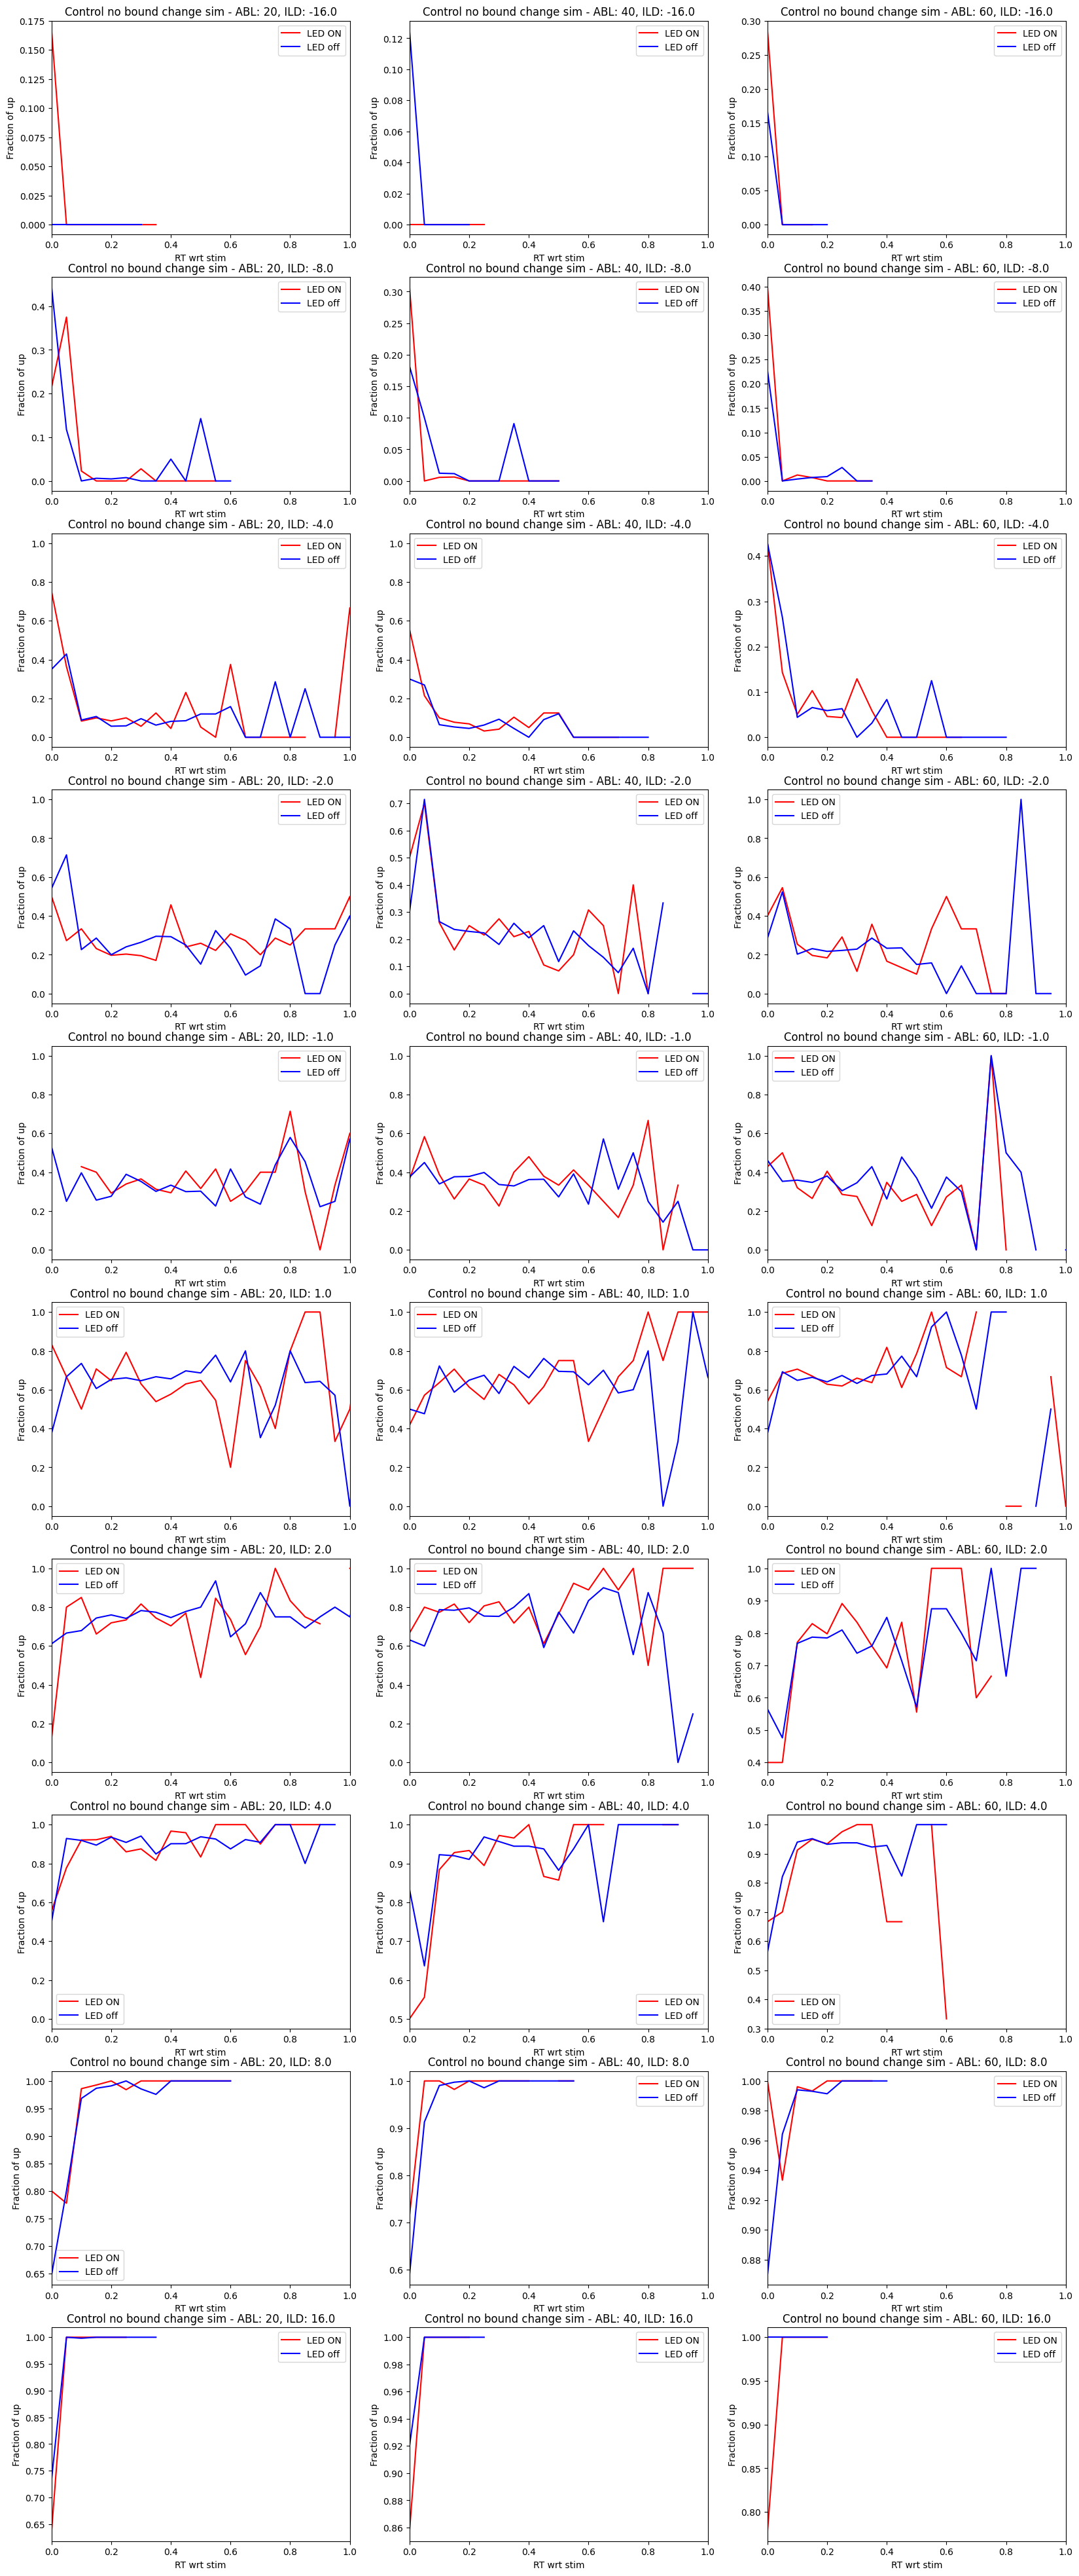

In [20]:
# base tacho
plt.figure(figsize=(20,50))
a = 1
for ILD in ILD_arr:
    for ABL in ABL_arr:

        plt.subplot(len(ILD_arr), len(ABL_arr),  a)

        if np.sum(base_total_and_up_counts_dict_on[(ABL, ILD)]['total']) == 0:
            continue

        if np.sum(base_total_and_up_counts_dict_off[(ABL, ILD)]['total']) == 0:
            continue
    
        plt.plot(t_bins, base_total_and_up_counts_dict_on[(ABL, ILD)]['up']/base_total_and_up_counts_dict_on[(ABL, ILD)]['total'],  color='red', label='LED ON')
        plt.plot(t_bins, base_total_and_up_counts_dict_off[(ABL, ILD)]['up']/base_total_and_up_counts_dict_off[(ABL, ILD)]['total'], color='blue', label='LED off')
        plt.xlabel('RT wrt stim')
        plt.ylabel('Fraction of up')
        plt.title(f'Control no bound change sim - ABL: {ABL}, ILD: {ILD}')
        plt.legend()
        plt.xlim(0, 1)
    
        a += 1

/tmp/ipykernel_2546703/415742295.py:15: RuntimeWarning: invalid value encountered in divide
  plt.plot(t_bins, new_total_and_up_counts_dict_on[(ABL, ILD)]['up']/new_total_and_up_counts_dict_on[(ABL, ILD)]['total'],  color='red', label='LED ON')
/tmp/ipykernel_2546703/415742295.py:16: RuntimeWarning: invalid value encountered in divide
  plt.plot(t_bins, new_total_and_up_counts_dict_off[(ABL, ILD)]['up']/new_total_and_up_counts_dict_off[(ABL, ILD)]['total'], color='blue', label='LED off')


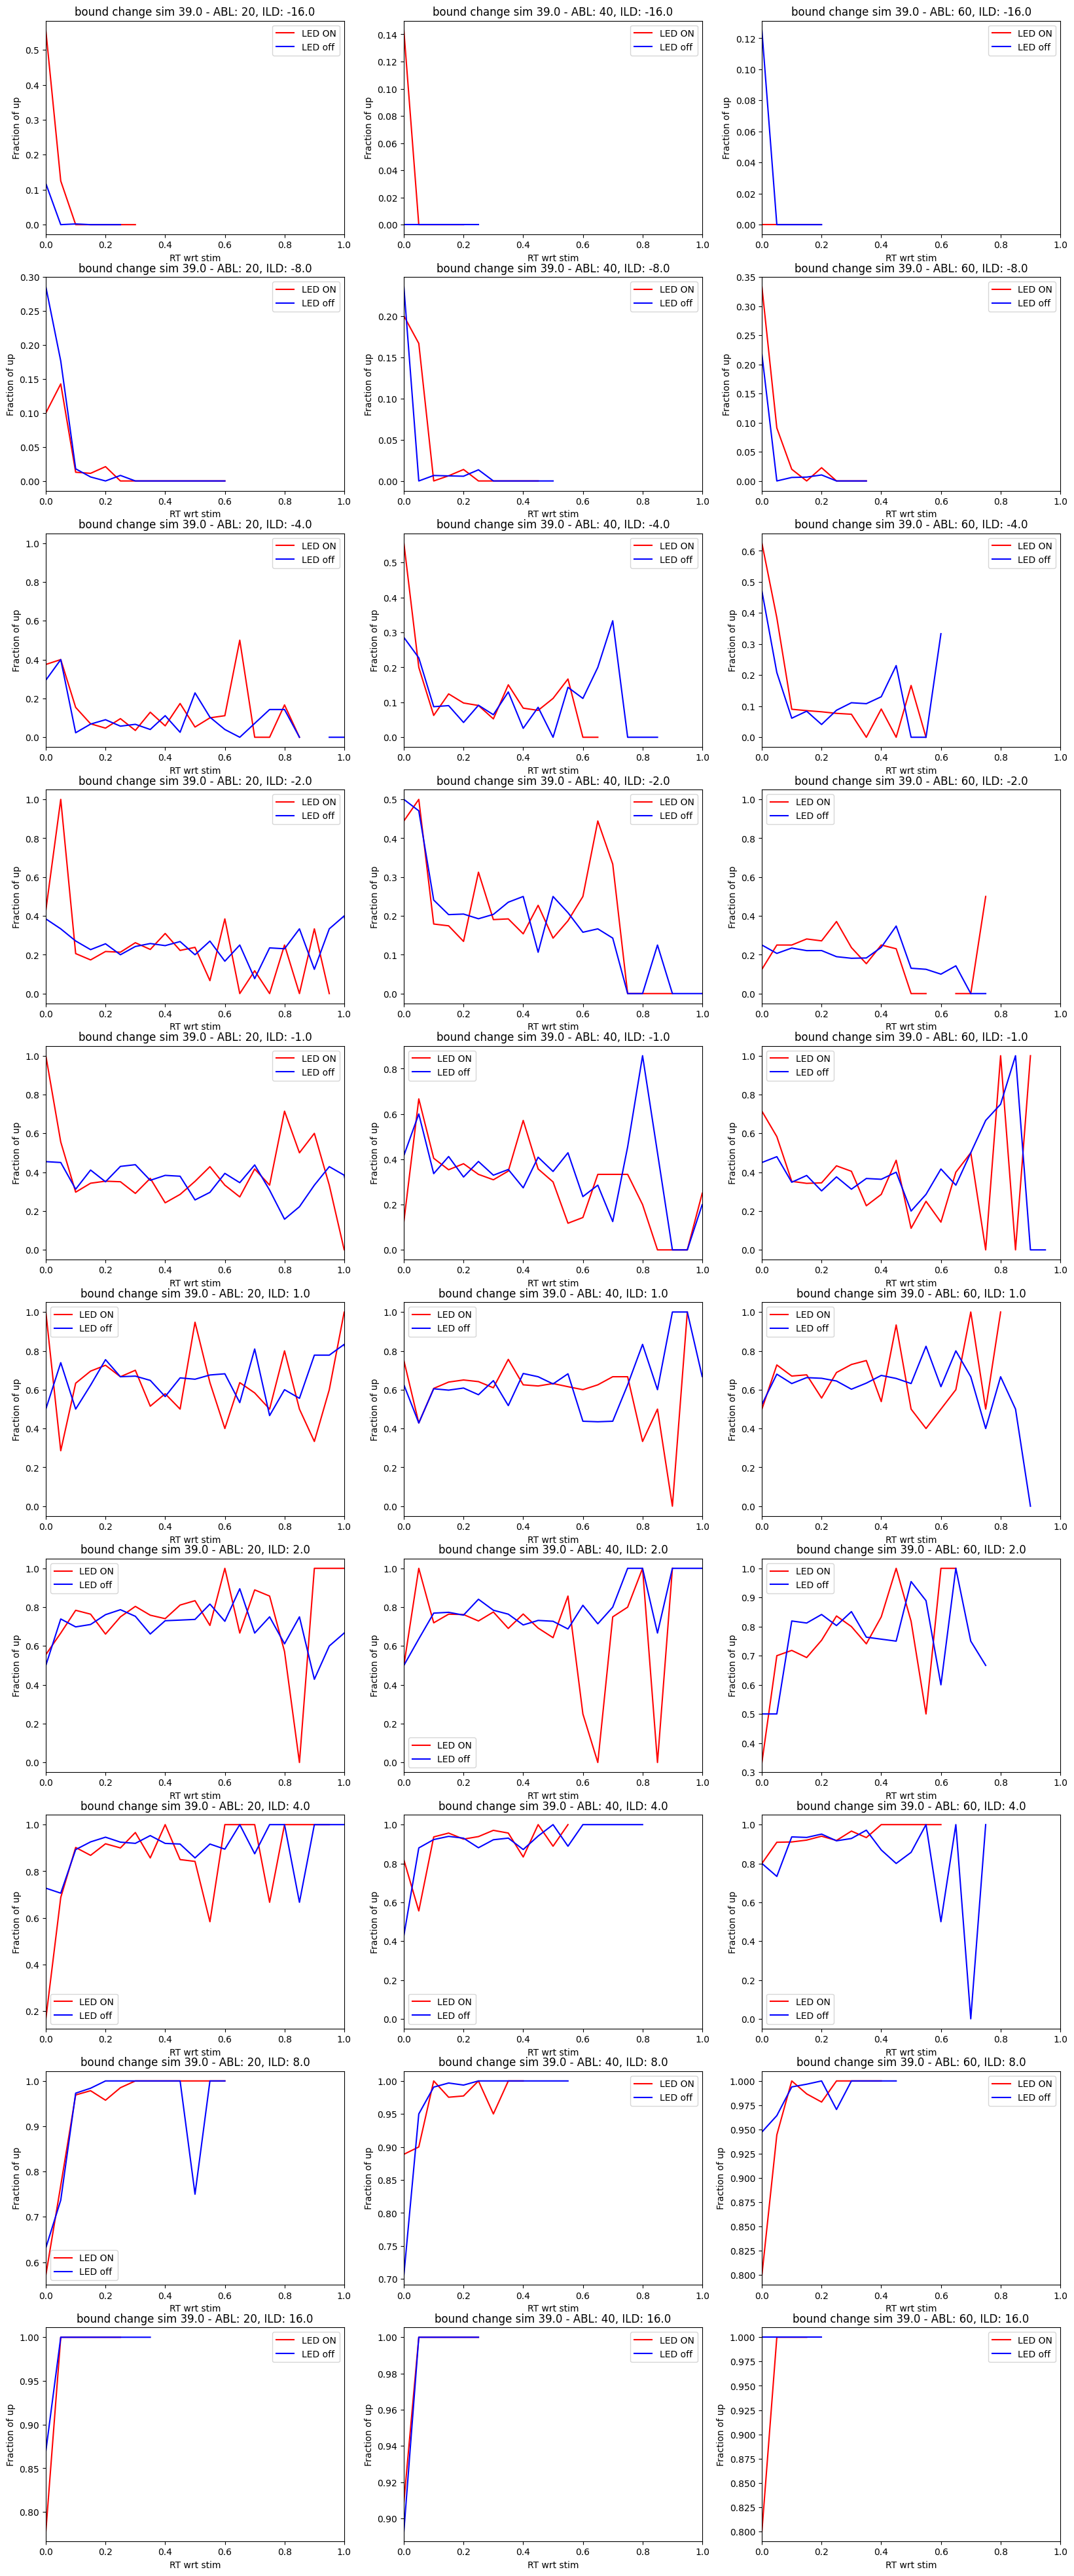

In [21]:
# change bound tacho
plt.figure(figsize=(20,50))
a = 1
for ILD in ILD_arr:
    for ABL in ABL_arr:

        plt.subplot(len(ILD_arr), len(ABL_arr),  a)

        if np.sum(new_total_and_up_counts_dict_on[(ABL, ILD)]['total']) == 0:
            continue

        if np.sum(new_total_and_up_counts_dict_off[(ABL, ILD)]['total']) == 0:
            continue
    
        plt.plot(t_bins, new_total_and_up_counts_dict_on[(ABL, ILD)]['up']/new_total_and_up_counts_dict_on[(ABL, ILD)]['total'],  color='red', label='LED ON')
        plt.plot(t_bins, new_total_and_up_counts_dict_off[(ABL, ILD)]['up']/new_total_and_up_counts_dict_off[(ABL, ILD)]['total'], color='blue', label='LED off')
        plt.xlabel('RT wrt stim')
        plt.ylabel('Fraction of up')
        plt.title(f'bound change sim {new_bound_value} - ABL: {ABL}, ILD: {ILD}')
        plt.legend()
        plt.xlim(0, 1)
    
        a += 1

# Grand mean and accuracy vs param

In [22]:
mean_vs_param_on_acc = np.zeros((N_params))
mean_vs_param_off_acc = np.zeros((N_params))


mean_vs_param_on_rt = np.zeros((N_params))
mean_vs_param_off_rt = np.zeros((N_params))



for i in range(N_params):
    results =  bound_change_results_dict[i]['results']
    
    on_total = 0
    on_correct = 0

    off_total = 0
    off_correct = 0

    for res in results:
        if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            on_total += 1
            if (res['ILD'] > 0 and res['choice'] == 1) or (res['ILD'] < 0 and res['choice'] == -1):
                on_correct += 1

        elif (not res['is_LED_trial']) and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            off_total += 1
            if (res['ILD'] > 0 and res['choice'] == 1) or (res['ILD'] < 0 and res['choice'] == -1):
                off_correct += 1

    mean_vs_param_on_acc[i] = on_correct / on_total
    mean_vs_param_off_acc[i] = off_correct / off_total





for i in range(N_params):
    results =  bound_change_results_dict[i]['results']

    on_rt = []
    off_rt = []

    for res in results:
        if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            on_rt.append(res['rt'] - res['t_stim'])
        elif (not res['is_LED_trial']) and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            off_rt.append(res['rt'] - res['t_stim'])

    mean_vs_param_on_rt[i] = np.mean(on_rt)
    mean_vs_param_off_rt[i] = np.mean(off_rt)



(-12.0, 0.5)

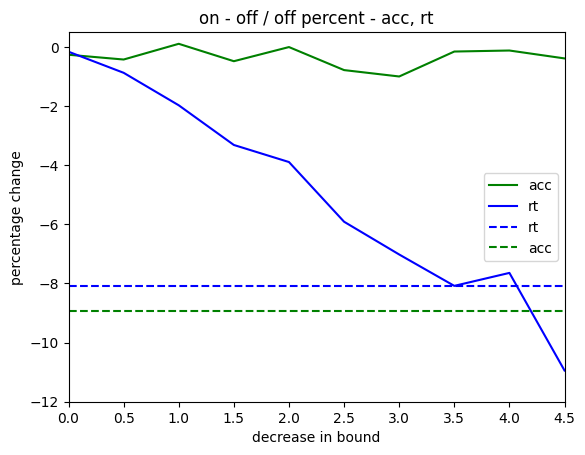

In [31]:
plt.plot([i * bound_step_size for i in range(N_params)], 100*(mean_vs_param_on_acc - mean_vs_param_off_acc)/mean_vs_param_off_acc, label='acc', color='g')
plt.plot([i * bound_step_size for i in range(N_params)], 100*(mean_vs_param_on_rt - mean_vs_param_off_rt)/mean_vs_param_off_rt, label='rt', color='b')

plt.axhline(-8.0781, label='rt', color='b', linestyle='--')
plt.axhline(-8.9482, label='acc', color='g', linestyle='--')

plt.xlabel('decrease in bound')
plt.ylabel('percentage change')
plt.legend()
plt.title('on - off / off percent - acc, rt');
plt.xlim(0,4.5)
plt.ylim(-12,0.5)